# Encoder-decoder: мост от RNN к трансформерам

Прогресс не стоит на месте и сейчас почти все лучшие модели машинного обучения используют под капотом другую архитектуру — transformer. 

Прежде чем приступить к разбору архитектуры трансформера, важно понять, как он появился. На появление трансформера повлияли три ключевые вещи:

- seq2seq-задача;

- encoder-decoder архитектура;

- механизм внимания в encoder-decoder архитектуре.

## Seq2Seq-задачи

В машинном обучении особое место занимают задачи, где и вход, и выход являются последовательностями переменной длины. Такие задачи называются sequence-to-sequence (seq2seq). Это важный класс задач, для которых не подходит простая классификация или регрессия, поскольку длина выходной последовательности заранее неизвестна и зависит от входа.

Примеры seq2seq-задач:

- Машинный перевод: вход — «I am a student», выход — «Я студент».
  
- Распознавание речи (speech-to-text): аудиосигнал (последовательность признаков) превращается в текст.
  
- Обобщение текста (summarization): вход — длинный текст, выход — краткое содержание.
  
- Генерация кода: вход — описание задачи, выход — сгенерированный код.
  
- Диалоговые агенты: вход — вопрос, выход — ответ.

Это далеко не все возможные примеры, seq2seq-задачи встречаются повсеместно.

Важно отметить, что не всякая NLP-задача является seq2seq. Например, классификация отзывов — это задача с фиксированным выходом (метка класса), она не требует генерации последовательности. Переменная длина и входа, и выхода — это единственное необходимое и достаточное условие, по которому можно определить seq2seq-задачу.

## Как выглядит датасет в seq2seq

В отличие от задач классификации, в seq2seq модель обучается по парам: "input_text" → "target_text".
Например:
```
"where is the bank?" → "wo ist die Bank?"
"good morning" → "guten Morgen" 
```
На этапе препроцессинга тексты преобразуются в токены:

- input_ids — токены входа (например, ["where", "is", "the", "bank", "?"]);

- target_ids — токены выхода (например, ["wo", "ist", "die", "Bank", "?"]).

>Таргет — это тоже последовательность токенов. 

Поэтому при генерации ответа можно рассматривать задачу как последовательное решение нескольких задач классификации: предсказание первого токена, второго и так далее. 

Это позволяет использовать функции потерь, как и для обычной классификации. 
Обычно используется кросс-энтропия.


## Архитектура encoder-decoder

Seq2seq-задачи сложно решать с помощью обычных RNN: они не очень хорошо справляются с длинными последовательностями. Эта проблема возникает и при генерации текста: чем больше текста RNN генерирует, тем сильнее она забывает о входной последовательности. Поэтому для решения seq2seq-задач были предложены специальные архитектуры — encoder-decoder.

>Суть архитектуры encoder-decoder в том, что она состоит из двух частей — кодировщика (encoder) и декодера (decoder).

## Encoder (кодировщик)

>Обрабатывает входную последовательность и формирует скрытое состояние — сжатое представление всей входной информации.


Пример: для текста "You know nothing, John Snow", encoder читает слова по порядку, итоговое скрытое состояние содержит информацию обо всём предложении.
В разных источниках Encoder может называться по-разному. Возможны варианты «кодировщик», «енкодер», «энкодер».

В этом уроке чаще будет использоваться слово «энкодер» или английский вариант “encoder“.

## Decoder (декодер)

>Генерирует выходную последовательность по шагам. На каждом шаге:

1. Получает скрытое состояние от предыдущего шага. На нулевом шаге используется скрытое состояние, полученное после чтения энкодером входной последовательности.
   
2. Берёт предыдущий сгенерированный токен. На нулевом шаге используется специальный токен `<eos>`, означающий начало последовательности.
    
3. Считает новое скрытое состояние, применяет к нему линейный слой, предсказывает следующее слово, которое нужно сгенерировать.

Верхнеуровнено:


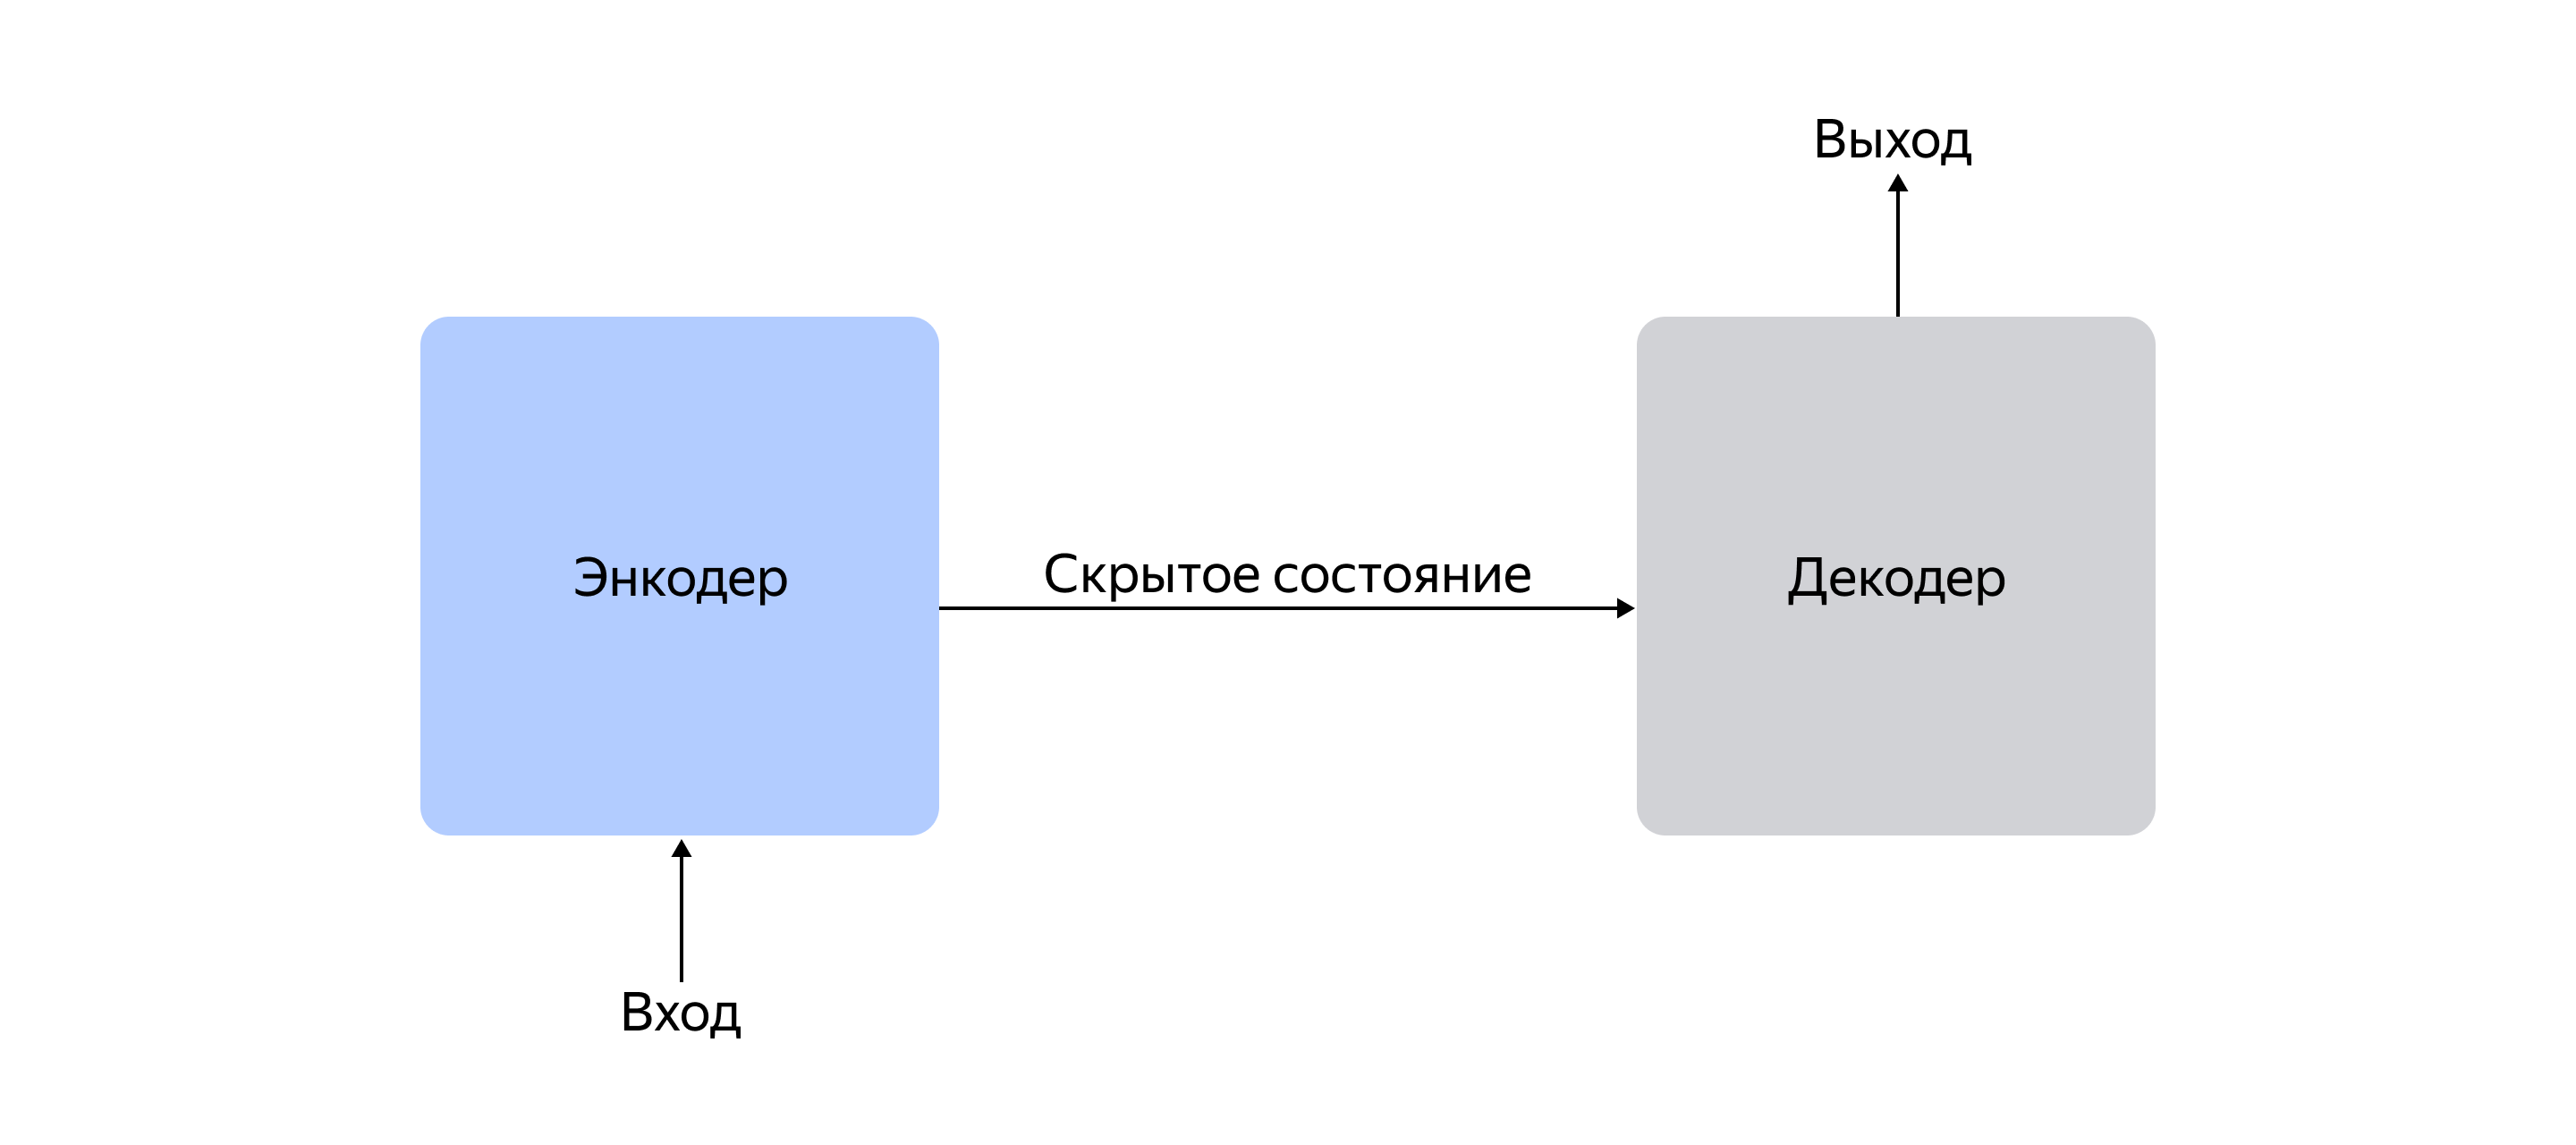

In [5]:
from IPython.display import Image
from ml_dl_experiments.settings import settings

path_to_summ = settings.SOURCE_PATH + "ml_dl/RNN/encoder_decoder_upper.png"
path_to_decomposition = settings.SOURCE_PATH + "ml_dl/RNN/encoder_decoder_decomposition.png"

Image(path_to_summ, width=700, height=1000)

Если мы декомпозируем, то увидим RNN в обоих случаях:

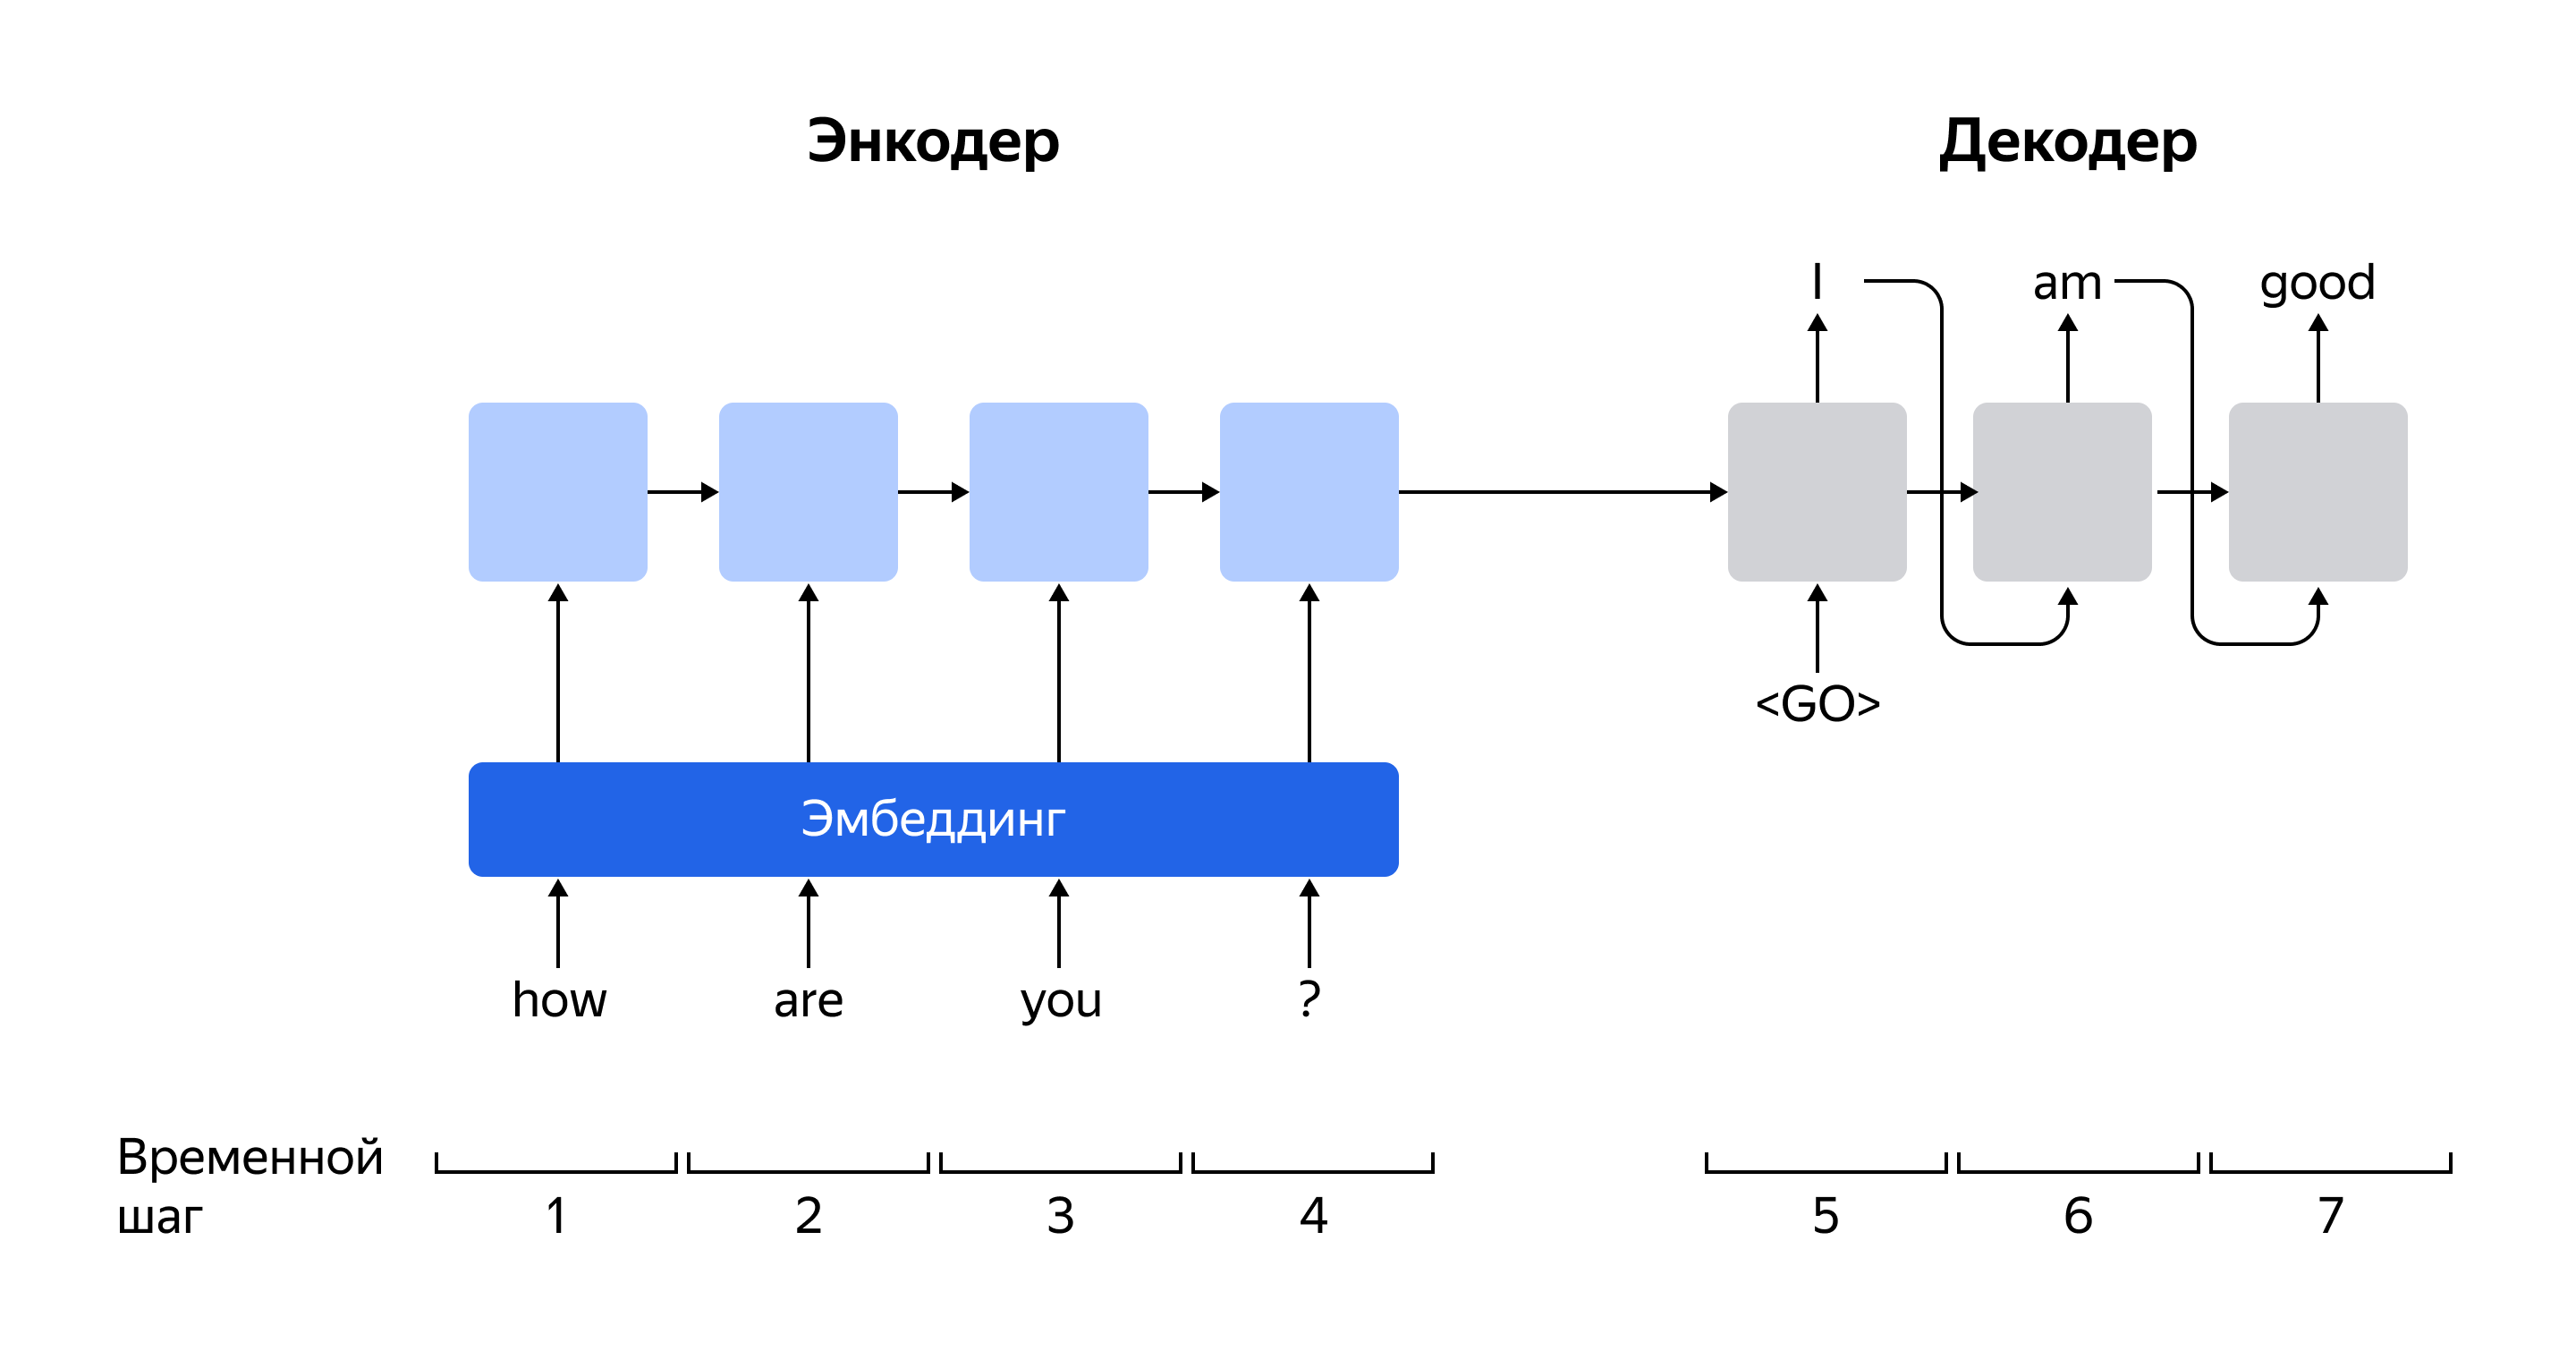

In [6]:
Image(path_to_decomposition, width=700, height=1000)

Механизм внимания (Attention)
Обычная encoder-decoder архитектура с рекуррентными сетями имеет одно проблемное место — передача скрытого состояния от энкодера к декодеру. Один вектор скрытого состояния от энкодера не может содержать всю информацию при длинных входах, его может быть просто недостаточно, чтобы сгенерировать достаточно хорошую выходную последовательность. Это ограничивает производительность и качество модели.
Для решения этой проблемы был придуман механизм внимания. Это часть архитектуры, позволяющая декодеру на каждом шаге смотреть на всю входную последовательность, а не только на скрытое состояние, посчитанное энкодером по всему входу. Механизм вычисляет веса внимания (attention weights), которые определяют важность каждого токена входа на данном шаге генерации.
Как это работает
На каждом шаге декодера:

    Скрытое состояние, посчитанное декодером, скалярно перемножается со всеми скрытыми состояниями из энкодера.
    На основе посчитанных произведений принимается решение, какие токены из входной последовательности важны, чтобы сгенерировать выход на этом шаге, а какие нет. Происходит вычисление весов внимания (обычно это softmax, применённый к произведениям скрытых состояний).
    На основе посчитанных весов внимания считается взвешенная сумма всех скрытых состояний из энкодера и получается контекстный вектор (context vector).
    К контекстному вектору применяется линейный слой и softmax, чтобы предсказать, какое слово сгенерировать следующим.